Test MSE: 2.490086e-06
Test Max |error|: 5.684520e-03


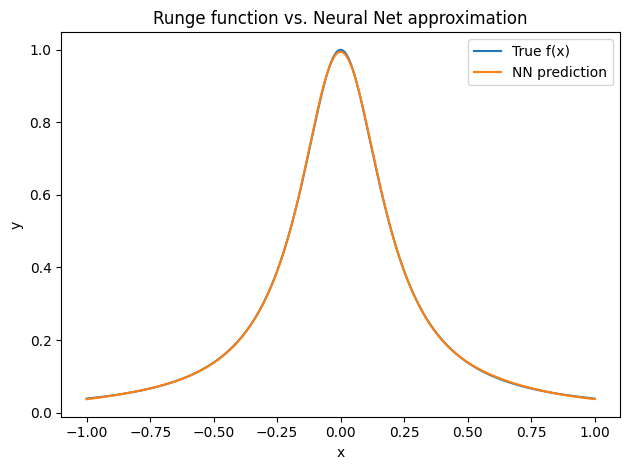

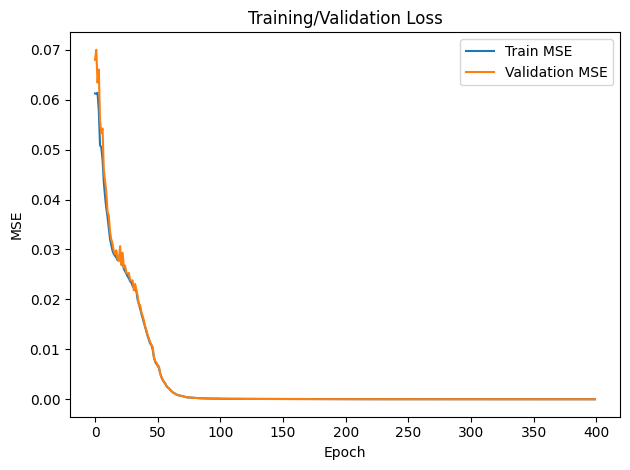

In [1]:
# Rerun quickly with fewer epochs to avoid timeout
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

def runge(x):
    return 1.0 / (1.0 + 25.0 * x**2)

n_train, n_val, n_test = 256, 256, 1000
x_train = np.random.uniform(-1.0, 1.0, size=(n_train, 1))
x_val   = np.random.uniform(-1.0, 1.0, size=(n_val, 1))
x_test  = np.linspace(-1.0, 1.0, n_test).reshape(-1, 1)

y_train = runge(x_train)
y_val   = runge(x_val)
y_test  = runge(x_test)

def to_tensor(a): return torch.from_numpy(a).float()
Xtr, Ytr = to_tensor(x_train), to_tensor(y_train)
Xva, Yva = to_tensor(x_val),   to_tensor(y_val)
Xte, Yte = to_tensor(x_test),  to_tensor(y_test)

train_ds = TensorDataset(Xtr, Ytr)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP()
opt = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

epochs = 400
train_losses, val_losses = [], []
best_val = float("inf")
best_state = None
patience, since_best = 60, 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr_loss = loss_fn(model(Xtr), Ytr).item()
        va_loss = loss_fn(model(Xva), Yva).item()
    train_losses.append(tr_loss); val_losses.append(va_loss)

    if va_loss < best_val - 1e-7:
        best_val = va_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

model.eval()
with torch.no_grad():
    Ypred = model(Xte).numpy()

mse = float(np.mean((Ypred - y_test)**2))
max_err = float(np.max(np.abs(Ypred - y_test)))

print(f"Test MSE: {mse:.6e}")
print(f"Test Max |error|: {max_err:.6e}")

# Plot: true function vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), Ypred.ravel(), label="NN prediction")
plt.title("Runge function vs. Neural Net approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()

# Plot: loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()


Test MSE: 2.316560e-02
Test Max |error|: 4.083370e-01


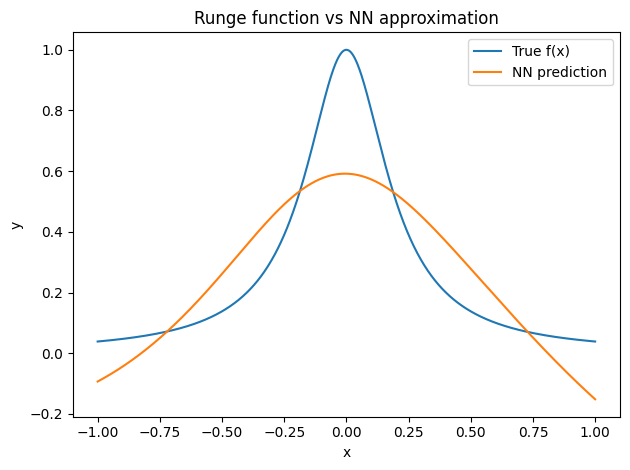

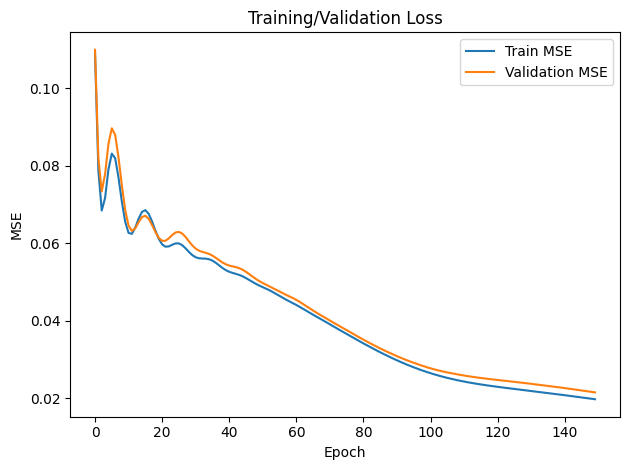

In [2]:
# Faster run: smaller net, full-batch training, fewer epochs
import numpy as np, torch
from torch import nn
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0)

def runge(x): return 1.0/(1.0+25.0*x**2)

# data
n_train, n_val, n_test = 256, 256, 1000
x_train = np.random.uniform(-1,1,(n_train,1)); y_train = runge(x_train)
x_val   = np.random.uniform(-1,1,(n_val,1));   y_val   = runge(x_val)
x_test  = np.linspace(-1,1,n_test).reshape(-1,1); y_test = runge(x_test)

Xtr = torch.tensor(x_train, dtype=torch.float32)
Ytr = torch.tensor(y_train, dtype=torch.float32)
Xva = torch.tensor(x_val, dtype=torch.float32)
Yva = torch.tensor(y_val, dtype=torch.float32)
Xte = torch.tensor(x_test, dtype=torch.float32)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x): return self.layers(x)

net = Net()
opt = torch.optim.Adam(net.parameters(), lr=2e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()

epochs = 150
train_losses = []; val_losses = []
for ep in range(epochs):
    net.train()
    pred = net(Xtr)
    loss = loss_fn(pred, Ytr)
    opt.zero_grad(); loss.backward(); opt.step()

    net.eval()
    with torch.no_grad():
        train_losses.append(loss_fn(net(Xtr), Ytr).item())
        val_losses.append(loss_fn(net(Xva), Yva).item())

# evaluate
net.eval()
with torch.no_grad():
    Ypred = net(Xte).numpy()

mse = float(np.mean((Ypred - y_test)**2))
max_err = float(np.max(np.abs(Ypred - y_test)))
print(f"Test MSE: {mse:.6e}")
print(f"Test Max |error|: {max_err:.6e}")

# plot f vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), Ypred.ravel(), label="NN prediction")
plt.title("Runge function vs NN approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()

# plot loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()


Test MSE: 1.282769e-02
Test Max |error|: 3.395851e-01


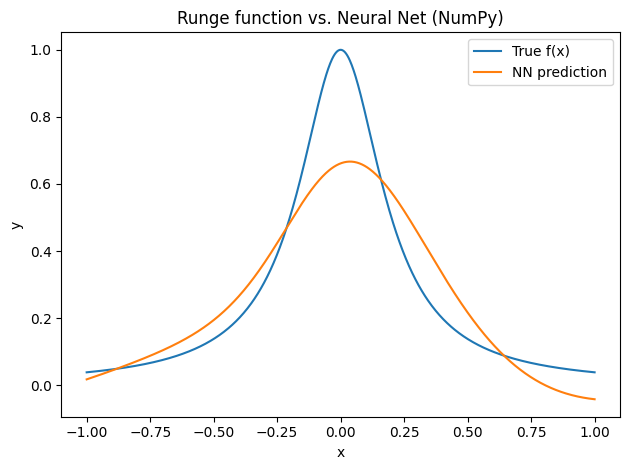

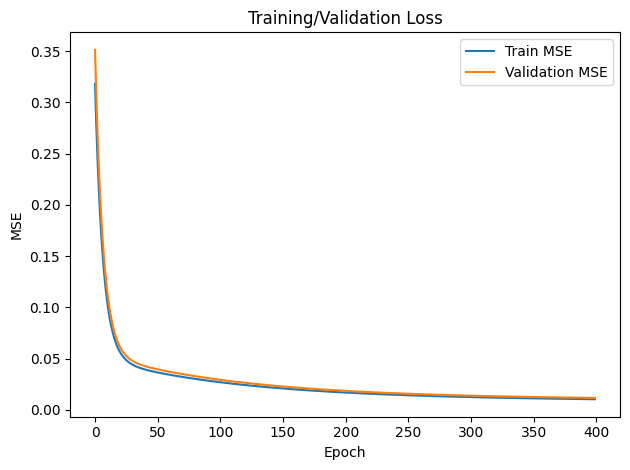

In [4]:
# Pure NumPy neural network to approximate the Runge function quickly (no PyTorch)
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def runge(x): 
    return 1.0/(1.0+25.0*x**2)

# data
n_train, n_val, n_test = 200, 200, 800
x_train = np.random.uniform(-1,1,(n_train,1)); y_train = runge(x_train)
x_val   = np.random.uniform(-1,1,(n_val,1));   y_val   = runge(x_val)
x_test  = np.linspace(-1,1,n_test).reshape(-1,1); y_test = runge(x_test)

# simple 1-32-32-1 tanh MLP with L2 weight decay
sizes = [1, 32, 32, 1]
W1 = np.random.randn(sizes[0], sizes[1]) * 0.5
b1 = np.zeros((1, sizes[1]))
W2 = np.random.randn(sizes[1], sizes[2]) * 0.5
b2 = np.zeros((1, sizes[2]))
W3 = np.random.randn(sizes[2], sizes[3]) * 0.5
b3 = np.zeros((1, sizes[3]))

def forward(X):
    z1 = X @ W1 + b1
    a1 = np.tanh(z1)
    z2 = a1 @ W2 + b2
    a2 = np.tanh(z2)
    y  = a2 @ W3 + b3
    cache = (X, z1, a1, z2, a2, y)
    return y, cache

def mse(yhat, y): 
    return np.mean((yhat - y)**2)

lr = 5e-3
wd = 1e-4
epochs = 400
train_losses = []; val_losses = []

for ep in range(epochs):
    # forward
    yhat, cache = forward(x_train)
    X, z1, a1, z2, a2, y = cache
    # loss + grad
    diff = (yhat - y_train) / len(y_train)
    dW3 = a2.T @ diff + wd * W3
    db3 = np.sum(diff, axis=0, keepdims=True)
    da2 = diff @ W3.T
    dz2 = (1 - np.tanh(z2)**2) * da2
    dW2 = a1.T @ dz2 + wd * W2
    db2 = np.sum(dz2, axis=0, keepdims=True)
    da1 = dz2 @ W2.T
    dz1 = (1 - np.tanh(z1)**2) * da1
    dW1 = X.T @ dz1 + wd * W1
    db1 = np.sum(dz1, axis=0, keepdims=True)
    # update
    W3 -= lr * dW3; b3 -= lr * db3
    W2 -= lr * dW2; b2 -= lr * db2
    W1 -= lr * dW1; b1 -= lr * db1

    # record losses
    yh_tr, _ = forward(x_train)
    yh_va, _ = forward(x_val)
    train_losses.append(mse(yh_tr, y_train))
    val_losses.append(mse(yh_va, y_val))

# evaluate
y_pred, _ = forward(x_test)
mse_test = mse(y_pred, y_test)
max_err = np.max(np.abs(y_pred - y_test))
print(f"Test MSE: {mse_test:.6e}")
print(f"Test Max |error|: {max_err:.6e}")

# plot predictions vs true
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), y_pred.ravel(), label="NN prediction")
plt.title("Runge function vs. Neural Net (NumPy)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout(); plt.show()

# plot loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()


---


Test MSE      : 2.070892e-06
Test Max |err|: 5.308021e-03


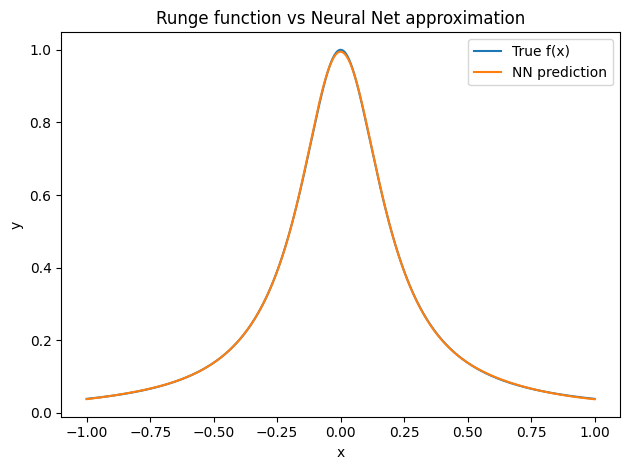

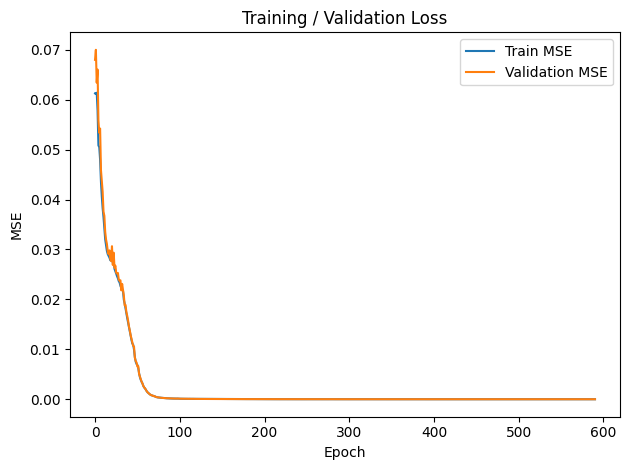

In [5]:
# Runge function approximation with a small neural network (PyTorch)
# 會畫兩張圖：f(x) vs NN、loss curves；並列印 MSE / Max error
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ---------- config ----------
seed = 42
n_train, n_val, n_test = 256, 256, 1000
hidden = 64
lr = 2e-3
weight_decay = 1e-5
epochs = 800
patience = 80
device = "cpu"

# ---------- utils ----------
torch.manual_seed(seed)
np.random.seed(seed)

def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)

# 建資料（均勻抽樣；想更漂亮可改用 Chebyshev 節點）
x_train = np.random.uniform(-1.0, 1.0, (n_train, 1))
x_val   = np.random.uniform(-1.0, 1.0, (n_val, 1))
x_test  = np.linspace(-1.0, 1.0, n_test).reshape(-1, 1)
y_train, y_val, y_test = f(x_train), f(x_val), f(x_test)

toT = lambda a: torch.from_numpy(a).float().to(device)
Xtr, Ytr = toT(x_train), toT(y_train)
Xva, Yva = toT(x_val),   toT(y_val)
Xte, Yte = toT(x_test),  toT(y_test)

train_dl = DataLoader(TensorDataset(Xtr, Ytr), batch_size=64, shuffle=True)

class MLP(nn.Module):
    def __init__(self, h=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, h), nn.Tanh(),
            nn.Linear(h, h), nn.Tanh(),
            nn.Linear(h, 1)
        )
    def forward(self, x): return self.net(x)

model = MLP(hidden).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

# ---------- train with early stopping ----------
train_losses, val_losses = [], []
best_val = float("inf"); best_state = None; since_best = 0

for ep in range(1, epochs+1):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb); loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        tr = loss_fn(model(Xtr), Ytr).item()
        va = loss_fn(model(Xva), Yva).item()
    train_losses.append(tr); val_losses.append(va)

    if va < best_val - 1e-7:
        best_val = va
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best >= patience:
            break

if best_state is not None:
    model.load_state_dict(best_state)

# ---------- evaluate ----------
model.eval()
with torch.no_grad():
    y_pred = model(Xte).cpu().numpy()

mse = float(np.mean((y_pred - y_test)**2))
max_err = float(np.max(np.abs(y_pred - y_test)))
print(f"Test MSE      : {mse:.6e}")
print(f"Test Max |err|: {max_err:.6e}")

# ---------- plots ----------
# 1) f(x) vs prediction
plt.figure()
plt.plot(x_test.ravel(), y_test.ravel(), label="True f(x)")
plt.plot(x_test.ravel(), y_pred.ravel(), label="NN prediction")
plt.title("Runge function vs Neural Net approximation")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout()
plt.show()

# 2) loss curves
plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training / Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout()
plt.show()
